<h1> <center> Compressive Sensing </center> </h1>

## Introduction
The principal problem of compressive sensing is to recover the sparse vector $x$ of size $N$ from linear observation $y$:

$$y = A \cdot x$$

when the number $m$ of observation is much lower than the number of unknows $N$.
Usually this type of problems are ill posed since $m << N$, but since the space of x is sparse, this problem has solution!

### Some Intuition

for example a 2 dimentional sparse space in a 3 dimentional word is


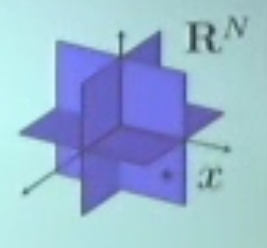

In [10]:
from IPython.display import Image
Image('spaziosparso.png',width=500)

So if we define a plane in this space we have that this plane will intersect 
the axis in some points... and the result for our problem are the one that minimize our objective function.

$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & ||x||_0 \\
& \text{subject to}
& & y = A \cdot x
\end{aligned}
\end{equation*}$$

But since this problem is non-convex and NP-hard. We relaxe the problem with other kind of spaces...


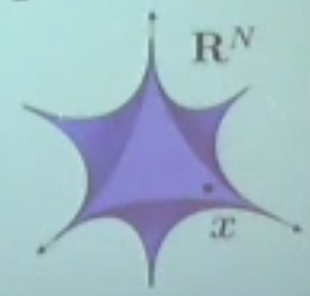

In [11]:
Image('normaP.png',width=500)

this picture show as a norm $p$ space when $p\leq 1$. But this spaces are still Non-Convex!!!
So under some condition we can relax to a norm 1 problem that has different recovery algorithms:



1) *Basis Pursuit*
$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & ||x||_1 \\
& \text{subject to}
& & y = A \cdot x
\end{aligned}
\end{equation*}$$

2) *Lasso*
$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & || A \cdot x - y||_2 \\
& \text{subject to}
& & ||x||_1 \leq \tau
\end{aligned}
\end{equation*}$$

3)*Orthogonal matching pursuit*
  * Initialization: $S^0 = \emptyset, \quad x^0 = 0$
  * Repeat until a stop criterion is met:
      *  $S^{n+1} = S^n \cup \{ j_{n+1}\}, \quad j_{n+1}= argmax\{|A^H(y- A\cdot x^n)|\}$
      * $x^{n+1} =  argmin_z\{|y - A \cdot z|_2 , supp(z) \subset S^{n+1}\}$
  * Output $x^* = x^{n+1}$


### **Conditions for unique recovery of sparse vectors**

Thanks to the results found by *Emmanuel Candès, Justin Romberg, Terence Tao and David Donoho*
we have the following theorems that says:

$$$$
### Th 1

**Given $A \in C^{m \times N}$, the following properties are equivalent**
  
1) *If $A\cdot x = A \cdot z$ and both $x$ and $z$ are s-sparse, then $x=z$*

2) *The null-space of $A$ does not contain and $2s$-sparse vector other than the $0$ vector*
   
3) *Every set of $2s$ columns of $A$ is linearly independent* 


$$$$
### Th 2

**Given $A \in C^{m \times N}$, with $l_2-$normalized columns, if ** 
$$\mu_1(s) + \mu_1(s+1) < 1$$

*Then every $s-$sparse vector $x$ is exactly recovered from the measurement vector $y = A \cdot x$ via basis pursuit or after at most s iterations of Orthogonal Matching Pursuit*

NOTE: the result hold if $\mu < \frac{1}{2s - 1}$


where:
$$\mu = \underset{1\leq i \neq j \leq N}{\text{max}} |\langle a_i , a_j \rangle| $$

$$\mu_1(s) = \underset{i \in [N]}{\text{max}}\; \text{max}\Bigg\{ \sum_{j \in S}  |\langle a_i , a_j \rangle|  \quad , S \subset [N], \; \text{card}(S)= s, \; i \notin S  \Bigg\}$$

![](spaziosparso.png)

In [0]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, figure, title

import numpy as np

import scipy 
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import dst, idst

import IPython.display as ipd

import cvxpy as cvx

from sklearn.linear_model import Lasso



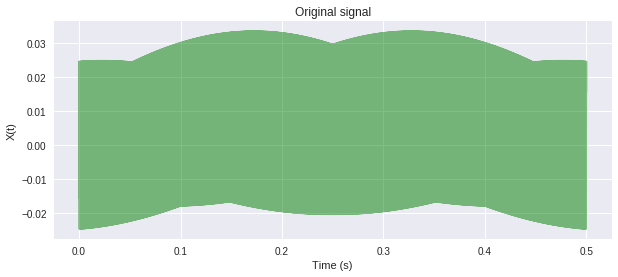

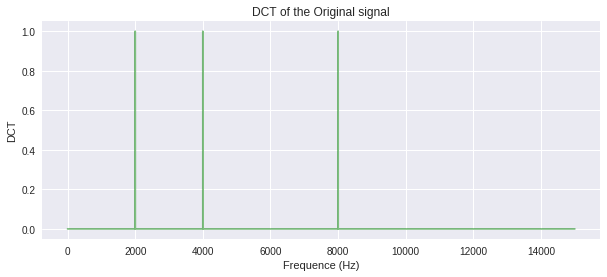

In [60]:
###########   Let's create a signal
Frequenze_udibili = 30e3
durata_suono = 1./2 # durata in secondi del suono
campioni = int(Frequenze_udibili*durata_suono)

X_f = np.zeros(campioni)

## frequenze per il segnale
f1 = 2000
f2 = 4000
f3 = 8000

X_f[[f1,f2,f3]] =  1

# signal cration
t = np.linspace(0,durata_suono,int(campioni))
X = idst(X_f, type=2, norm='ortho')

figure(figsize=[10,4])
plot(t,X, 'g', alpha=0.5)
title('Original signal')
plt.pyplot.xlabel('Time (s)')
plt.pyplot.ylabel('X(t)')

## Discrete transform
figure(figsize=[10,4])
plot(dst(X, type=2, norm='ortho', n = campioni),'g', alpha = 0.5)
title('DCT of the Original signal')
plt.pyplot.xlabel('Frequence (Hz)')
plt.pyplot.ylabel('DCT')


## listen
ipd.Audio(X, rate=Frequenze_udibili)

Following the **Shannon-Nyquist** Theorem we should sample each $\frac{1}{2B}= \frac{1}{2\cdot 8000}= 0,0000625 \; s$!  That means that in a second we need $\frac{1 \; s}{0,0000625 \; s} = 16000$ sampled values

But exploiting the Compressive Sensing theory, and looking for a random matrix A that has low coherence, we can...

Sampling time for Compressive sampling 0.001000000
Compression respect the Shannon-yquist 0.062500000


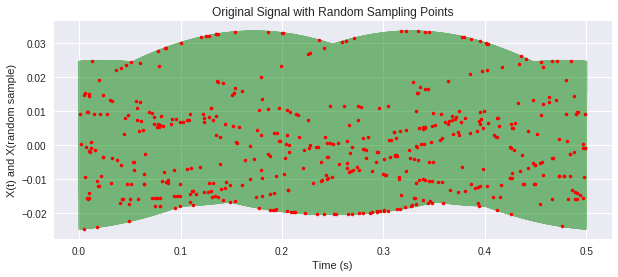

In [61]:
### lower frequence sampling
sampled_compr = 500
yi = np.random.randint(0,campioni,sampled_compr)
yi = np.sort(yi)

Y = X[yi]

figure(figsize=[10,4])
plot( t, X, 'g', alpha=0.5)
plot(t[yi], Y, 'r.', alpha=1.)
title('Original Signal with Random Sampling Points')
plt.pyplot.xlabel('Time (s)')
plt.pyplot.ylabel('X(t) and X(random sample)')

print("Sampling time for Compressive sampling {:1.9f}".format(1./(sampled_compr*2)))
print("Compression respect the Shannon-yquist {:1.9f}".format((sampled_compr*2)/16000.))

D = dst(np.eye(campioni), type=2, norm= 'ortho')  # Construct the DCT basis functions for each of the frequencies
A = D[yi,: ]                  # Downsample based on our random sampling


In this simple example we create a particular random matrix, that exploit the fact that the sine basis of the DST are orthonormal and thus if we take enough samples the coherence of the matrix will be small,  builted such a way that:

$$A  =  \text{diag}(\delta) \cdot D $$

where the vector $\delta$ is builted from a sample of Bernoulli Variables, while $D$ is the DST basis.


## Basis Pursuit for reconstruction

In [86]:
m = A.shape[1]
x = cvx.Variable(m)

objective = cvx.Minimize( cvx.norm(x, p=1))
constraint = [Y == A*x]

prob = cvx.Problem(objective, constraint)
prob.solve()


2.9999999999999982

Solution is %0.000 sparse


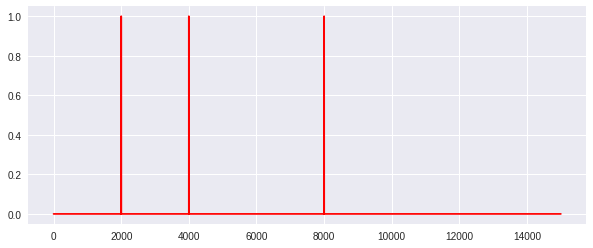

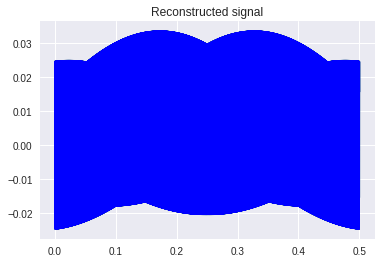

In [91]:
figure(figsize=[10,4])
freq_pred_BP = x.value
plot(freq_pred_BP, 'r',alpha = 1.)

sparseness = (np.sum(x.value == 0)+ 0.)/campioni
print("Solution is %{:0.3f} sparse".format(100.*sparseness))

Xhat_BP = idst(freq_pred_BP, type=2, norm='ortho')
figure()
plot(t, X,'g-',t, Xhat_BP, 'b-')
title('Reconstructed signal')


## listen
ipd.Audio(Xhat_BP, rate=Frequenze_udibili)


## LASSO for reconstruction

Solution is %99.980 sparse


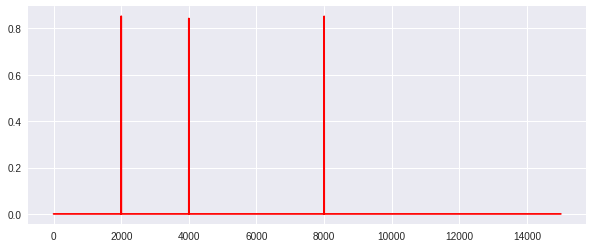

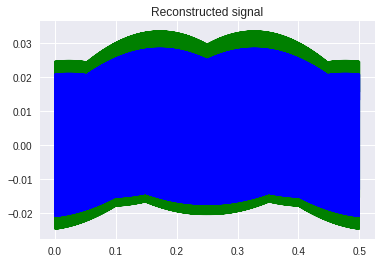

In [70]:
lasso = Lasso(alpha=0.00001)
lasso.fit(A,Y)

figure(figsize=[10,4])
freq_pred_LASSO = lasso.coef_
plot(freq_pred_LASSO, 'r',alpha = 1.)

sparseness = (np.sum(lasso.coef_ == 0)+ 0.)/campioni
print("Solution is %{:0.3f} sparse".format(100.*sparseness))

Xhat_LASSO = idst(freq_correct, type=2, norm='ortho')
figure()
plot(t, X,'g-',t, Xhat_LASSO, 'b-')
title('Reconstructed signal')


## listen
ipd.Audio(Xhat, rate=Frequenze_udibili)


## Orthogonal Matching Pursuit for reconstruction

In [0]:
def matching_pursuit(A, signal, iterations = 30):
    residual = np.copy(signal)
    Dictionary = np.copy(A)
    it = 1
    coeffs = []
    indici = [i for i in range(Dictionary.shape[1])]
    for i in range(iterations):
        col_new = np.argmax(np.abs(np.dot(residual, Dictionary)))
        coeffs.append(indici.pop(col_new))
        Dictionary = np.delete(Dictionary , col_new, axis=1)
        X = np.copy(A[:, coeffs])
        a_n = np.dot(np.dot(   np.linalg.inv( np.dot(  X.T, X ) ), X.T), signal)    # beta = (X.t * X)^-1 X.t y      
        residual -=  np.dot(A[:, coeffs], a_n)
        it += 1
    return np.array(coeffs)
  

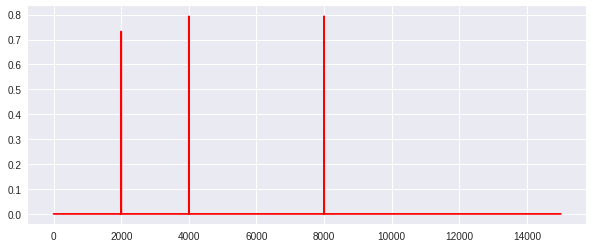

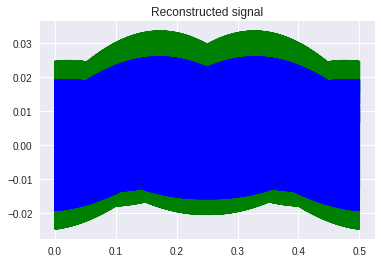

In [82]:
coefs_MP = matching_pursuit(A, Y)

freq_pred_MP = np.zeros(15000)
freq_pred_MP[coefs[:,0].astype(np.int)] = coefs[:,1]

figure(figsize=[10,4])
plot(freq_pred_MP, 'r',alpha = 1.)

Xhat_MP = idst(freq_pred_MP, type=2, norm='ortho')
figure()
plot(t, X,'g-',t, Xhat_MP, 'b-')
title('Reconstructed signal')




## listen
ipd.Audio(Xhat_MP, rate=Frequenze_udibili)



## But in real cases ???

In real cases we have the problem that is hard to find an low coherence matrix that has a sparse rappresentation of the signal then we need to build also this matri using Dictionary Learning methods

In [98]:
i,h =0,0     ##### noise  19,3

train_audio_path = './my_data'
words = os.listdir("./my_data/")
file = os.listdir("./my_data/"+ words[i])[h]
filename = '/'+words[i] + '/'+ file
print(words[i], file)
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
#samples = samples[np.abs(samples)>100]
print(len(samples))
ipd.Audio(samples, rate=sample_rate)

('six', 'caa7feaf_nohash_1.wav')
16000


Text(0.5,0,u'Seconds')

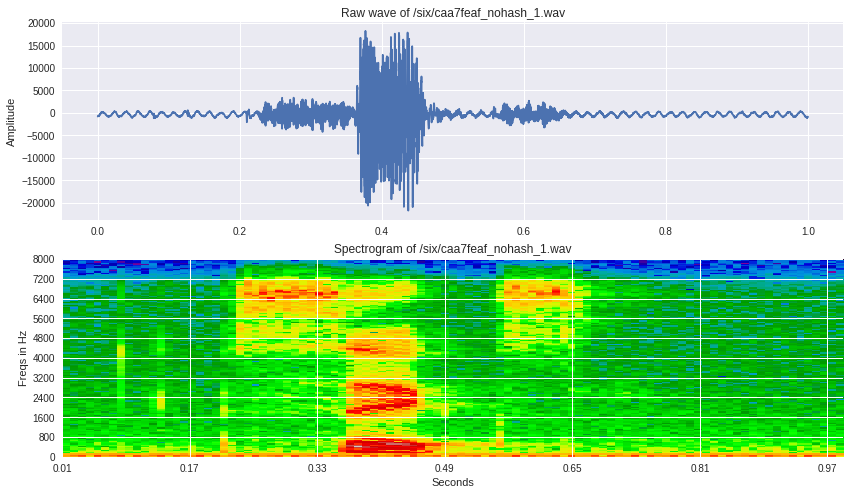

In [103]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
  
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples) / (sample_rate+1e-10), len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap = "nipy_spectral")
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Dicionary Learning algorithm

In [0]:
words = [w for w in os.listdir("./my_data/") if w not in ['datalab','.ipython','my_data.zip','.cache',]]

def my_split(arr):
  splitted = []
  win = 300
  numb = len(arr)//win
  resto = len(arr) % win
  for i in range(numb):
    splitted.append(arr[i*win:(1+i)*win])
  if resto>0:
    splitted.append(np.pad(arr[(numb)*win:], pad_width=(0, win-resto), mode="constant"   ))
  return splitted

In [104]:
# creo il dataset su cui fittare il dictionary learning
data = []
it = 0
files = {}
for w in words:
  #if w != "_background_noise_":
    nu = 0
    for file in os.listdir("./my_data/"+ w):
      filename = '/'+ w + '/'+ file
      try:
        sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
        if len(samples)>15890:
          samples = samples[:15890]

        files[it] = (file,len(samples), w , nu)
        data.extend(my_split(samples))
        it +=1
        nu +=1

      except:
        pass
        #print(w, file)


print("total numbers of signals: {} ### number of different voices: {} ".format(len(data), it))
data = np.array(data)
data.shape

/usr/local/lib/python2.7/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


total numbers of signals: 15895 ### number of different voices: 306 


(15895, 300)

## my own Dictionary Learning Class


In [93]:
n, m = 10, 100
y = np.random.randn(n)

phi = np.random.randn(n, m)
a = cvx.Variable(m)

error = cvx.sum_squares(y - phi*a)
prob = cvx.Problem(cvx.Minimize(error + cvx.norm(a, 1)))
prob.solve()

1.5520652271974988

In [92]:
D = np.random.randn(100,1000)
D = D / np.linalg.norm(D, axis=0)
y = np.random.randn(100)

d = DictionaryLearning(dimensione_dizionario=10, alpha=100, iterazioni=100)
coef = d.matching_pursuit(D,y)
len(coef)

235

In [0]:
class DictionaryLearning:
  def __init__(self, dimensione_dizionario, alpha, iterazioni):
    self.dimensione_dizionario = dimensione_dizionario
    self.alpha = alpha
    self.iterazioni = iterazioni
    
  

In [2]:
from time import time
from sklearn.decomposition import MiniBatchDictionaryLearning

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=1000, alpha=0.01, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

Learning the dictionary...


NameError: ignored

In [47]:
V.shape

(1000, 200)

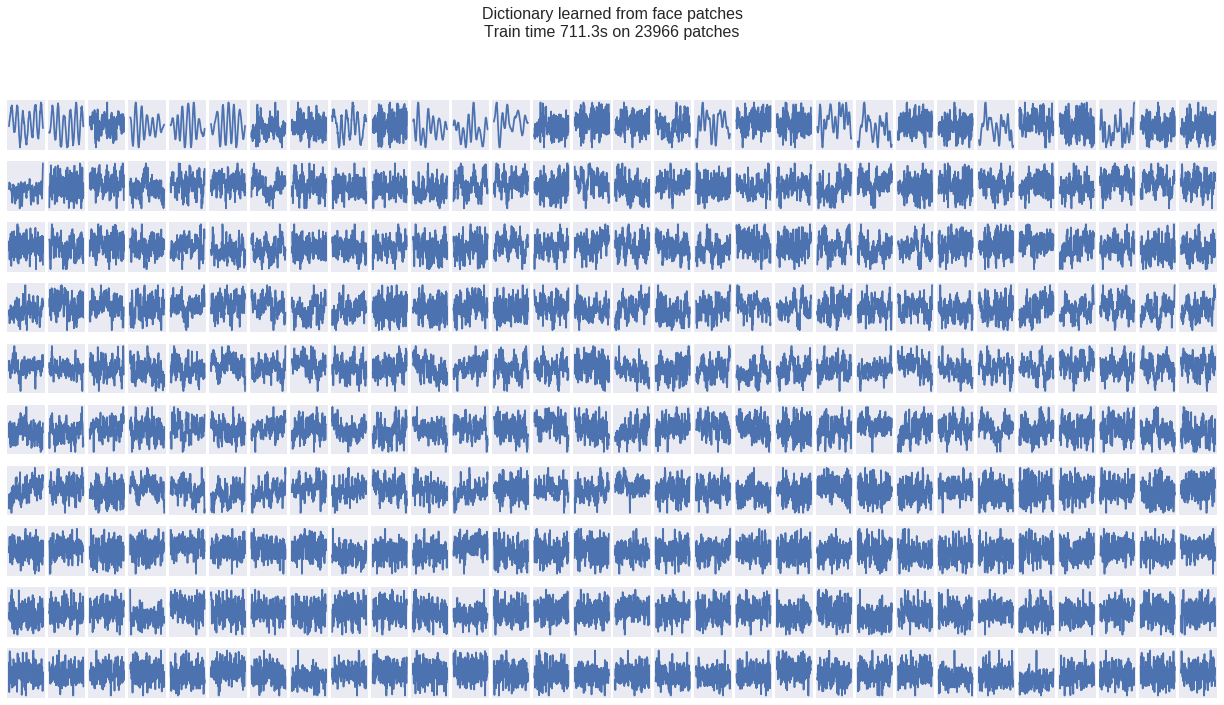

In [48]:
plt.figure(figsize=(20, 10))
for i, comp in enumerate(V[:300]):
    plt.subplot(10, 30, i + 1)
    plt.plot(np.linspace(0, 1, len(comp)), comp)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


In [55]:
print("rebuilding the signals .... ")
t0 = time()
dico.set_params(transform_algorithm='omp', **{'transform_n_nonzero_coefs': 20})
code = dico.transform(data)
patches = np.dot(code, V)
dt = time() - t0
print('done in %.2fs.' % dt)



rebuilding the signals .... 
done in 152.15s.


In [0]:
def rebuild_all_from_dic(matrix):
  global files
  attuale = 0
  win = 200
  ritorno = []
  for k in range(len(files)):
    lunghezza_file = files[k][1]
    num = files[k][1]//win
    resto = int(bool(files[k][1] % win))
    ritorno.append(   matrix[attuale: (num + resto + attuale)].flatten()    )
    attuale += num + resto
    
  return ritorno

all_rec = rebuild_all_from_dic(patches)
real_data = rebuild_all_from_dic(data)

file:  6c0f6493_nohash_0.wav 
lunghezza campioni: 15890 
parola:  eight 
registrazione numero: 1 


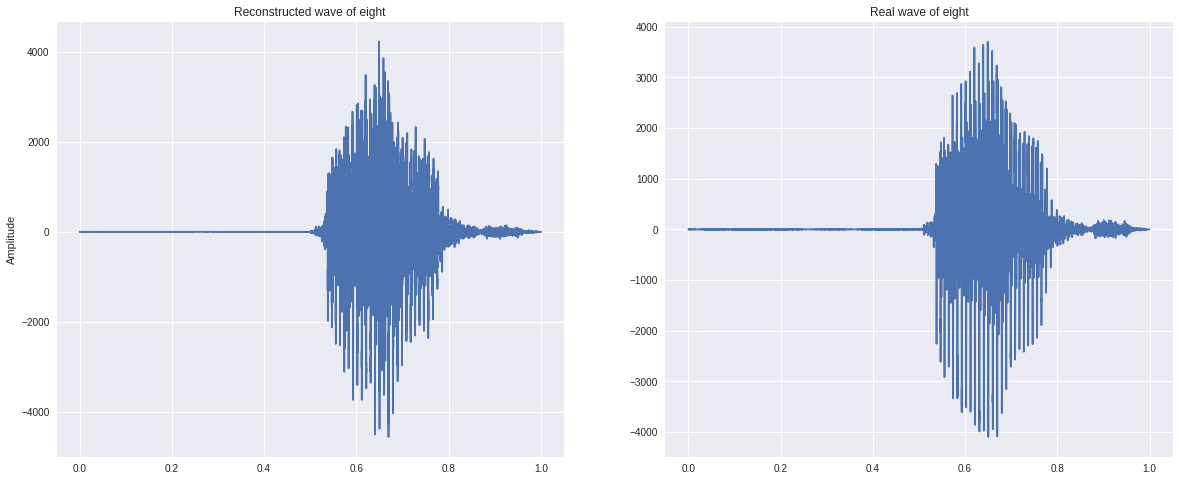

In [57]:
el = 1         #####  noise 192
sign_reco = all_rec[el]
real_sign = real_data[el]
print("file:  %s \nlunghezza campioni: %i \nparola:  %s \nregistrazione numero: %i " % files[el])

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.set_title('Reconstructed wave of ' + files[el][2])
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(sign_reco) / (sample_rate+1e-10), len(sign_reco)), sign_reco)

ax2 = fig.add_subplot(122)
ax2.set_title('Real wave of ' + files[el][2])
ax2.plot(np.linspace(0, len(real_sign) / (sample_rate+1e-10), len(sign_reco)), real_sign)



ipd.Audio(sign_reco, rate=sample_rate)

In [58]:
ipd.Audio(real_sign, rate=sample_rate)

# Using Dictionary Learning for Classification problem

#### Loading data

In [1]:
!ls

datalab


In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving my_data.zip to my_data.zip
User uploaded file "my_data.zip" with length 17838507 bytes


In [3]:
!mkdir my_data
!unzip my_data.zip -d my_data

mkdir: cannot create directory ‘my_data’: File exists
Archive:  my_data.zip
replace my_data/cat/78102205_nohash_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


#### Installing Library


In [4]:
!pip install cvxpy

### Exploring CVXPY package

In [0]:
import cvxpy as cvx
import numpy
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 10
numpy.random.seed(1)
A = numpy.random.randn(n, m)
b = numpy.random.randn(n)

# gamma must be nonnegative due to the DCP rules
gamma = cvx.Parameter(nonneg= True)

# Construct the problem.
x = cvx.Variable(m)
error = cvx.sum_squares(A*x - b)
obj = cvx.Minimize(error + gamma*cvx.norm(x, 1))
prob = cvx.Problem(obj)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []
gamma_vals = numpy.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cvx.norm(x, 1).value)
    x_values.append(x.value)



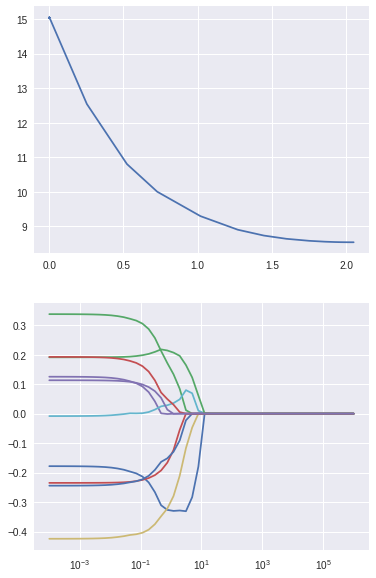

In [3]:
plt.figure(figsize=(6,10))

# Plot trade-off curve.
plt.subplot(211)
plt.plot(l1_penalty, sq_penalty)

# Plot entries of x vs. gamma.
plt.subplot(212)
for i in range(m):
    plt.plot(gamma_vals, [xi[i] for xi in x_values])
   

plt.xscale('log')





In [0]:
from multiprocessing import Pool

# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    result = prob.solve()
    return x.value

# Parallel computation (set to 1 process here).
pool = Pool(processes = 5)
x_values = pool.map(get_x, gamma_vals)